In [1]:
import os
import sys

In [2]:
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

In [3]:
if is_colab():
    from google.colab import drive
    drive.mount('/content/drive')
    
    # code required by Colab
    %cd /content/drive/MyDrive/PatMatBaselineAlena
    
    root_dir = '/content/drive/MyDrive/PatMatBaselineAlena'
else:
    current_dir = os.getcwd()
    root_dir = '..'
    %cd ..

c:\Users\alena\MyFolder\DIL\PatentMatchBaselineAlena


c:\Users\alena\MyFolder\DIL\PatentMatchBaselineAlena\venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
current_dir = os.getcwd()
print(current_dir)

c:\Users\alena\MyFolder\DIL\PatentMatchBaselineAlena


In [5]:
# parent_dir = os.path.abspath(os.path.join(os.getcwd(), root_dir))
sys.path.append(current_dir)

In [6]:
# install requirements
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import json
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, matthews_corrcoef, roc_auc_score, average_precision_score, log_loss
import numpy as np
import numpy as np
from datetime import datetime
import mlflow

c:\Users\alena\MyFolder\DIL\PatentMatchBaselineAlena\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# # this code uploads the credentials to MLflow given in the .env file
from src.settings import (
    MLFLOW_TRACKING_URI,
    MLFLOW_TRACKING_USERNAME,
    MLFLOW_TRACKING_PASSWORD,
    path_1
)

In [9]:
print(MLFLOW_TRACKING_USERNAME)

Alena


In [10]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
device

device(type='cpu')

In [12]:
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [13]:
# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Move the model to the proper device
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [15]:
def load_jsonl(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

train_data = load_jsonl('data/train_v2.jsonl')
validation_data = load_jsonl('data/test_v2.jsonl')

# Prepare the texts and labels
train_texts = [(item['text'], item['text_b']) for item in train_data]
train_labels = [item['label'] for item in train_data]
validation_texts = [(item['text'], item['text_b']) for item in validation_data]
validation_labels = [item['label'] for item in validation_data]

In [16]:
len(train_texts), len(train_labels), len(validation_texts), len(validation_labels)

(2920, 2920, 730, 730)

In [17]:
# If you don't have a GPU, limit the amount of data
if device.type == 'cpu':
    train_texts = train_texts[:10]
    train_labels = train_labels[:10]
    validation_texts = validation_texts[:10]
    validation_labels = validation_labels[:10]

In [18]:
# Define a dictionary with model configuration and hyperparameters
# Consider changing the number of epochs if you want to observe longer training
config = {
    'learning_rate': 2e-5,
    'batch_size': 32,
    'num_epochs': 7,
    'max_length': 512,
    'test_size': 0.2,
    'random_state': 42,
}

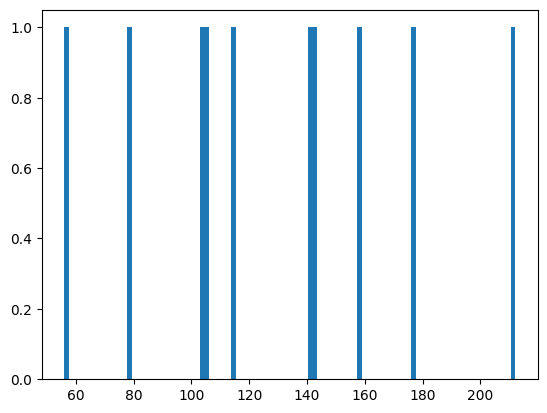

In [19]:
doc1_and_doc2 = []

for item in validation_texts:
    doc1_and_doc2.append(item[0] + " " + item[1])

# Visualize the distribution of the length of the 2 documents combined together
import matplotlib.pyplot as plt
plt.hist([len(item.split()) for item in doc1_and_doc2], bins=100)
plt.show()

In [20]:
train_encodings = tokenizer(train_texts, padding=True, truncation=True, return_tensors="pt", max_length=config['max_length'])
validation_encodings = tokenizer(validation_texts, padding=True, truncation=True, return_tensors="pt", max_length=config['max_length'])

train_input_ids = train_encodings['input_ids']
train_attention_mask = train_encodings['attention_mask']
validation_input_ids = validation_encodings['input_ids']
validation_attention_mask = validation_encodings['attention_mask']

# Convert labels to tensors
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)

In [21]:
train_input_ids.shape, train_attention_mask.shape, validation_input_ids.shape, validation_attention_mask.shape

(torch.Size([10, 271]),
 torch.Size([10, 271]),
 torch.Size([10, 268]),
 torch.Size([10, 268]))

In [22]:
train_labels.shape, validation_labels.shape

(torch.Size([10]), torch.Size([10]))

In [23]:
train_data = TensorDataset(train_input_ids, train_attention_mask, train_labels)
validation_data = TensorDataset(validation_input_ids, validation_attention_mask, validation_labels)

In [24]:
train_data.tensors[0].shape, train_data.tensors[1].shape, train_data.tensors[2].shape

(torch.Size([10, 271]), torch.Size([10, 271]), torch.Size([10]))

In [25]:
validation_data.tensors[0].shape, validation_data.tensors[1].shape, validation_data.tensors[2].shape

(torch.Size([10, 268]), torch.Size([10, 268]), torch.Size([10]))

In [26]:
train_dataloader = DataLoader(train_data, batch_size=config["batch_size"])
validation_dataloader = DataLoader(validation_data, batch_size=config["batch_size"])


In [27]:
for batch in train_dataloader:
    print(batch[0].shape, batch[1].shape, batch[2].shape)
    break

torch.Size([10, 271]) torch.Size([10, 271]) torch.Size([10])


In [28]:
# Define the optimizer
optimizer = AdamW(model.parameters(), lr=config['learning_rate'], no_deprecation_warning=True)

In [29]:
print(MLFLOW_TRACKING_USERNAME)

Alena


In [30]:
# This variable along with the timestamp will be used to create the name of the experiment run. By default, this is the MLflow username, but you can change it as you like.
user = MLFLOW_TRACKING_USERNAME
# This variable will be the name of the folder in MLflow. You can change it as you wish.
# If you provide the name of an already existing experiment, the experiment runs will be saved in the specified folder.
# If you provide the name of a non-existent experiment, you will create a new folder with the given name.
experiment_name = 'Alena_PatentMatchBaseline'


def timestamp():
    """This function creates current timestamp"""
    return datetime.now().strftime("%Y_%m_%d_%H%M_%S")

In [31]:
# If you have provided the name of an experiment that does not exist or that existed in MLflow but was deleted, create a new experiment.
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None or experiment.lifecycle_stage == 'deleted':
    mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment_by_name(experiment_name)

In [32]:
model_save_path = 'models/'

if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

In [33]:
with mlflow.start_run(experiment_id=experiment.experiment_id):
    for param_name, param_value in config.items():
        mlflow.log_param(param_name, param_value)

    best_val_loss = float('inf')  # Initialize the best validation loss to infinity

    for epoch in range(config['num_epochs']):  # Number of training epochs
        # Set run name
        mlflow.set_tag(key='mlflow.runName',
                       value=f'{timestamp()}_{user}')
        model.train()
        train_loss = 0.0
        for batch in train_dataloader:
            b_input_ids, b_attention_mask, b_labels = batch

            # Move the batch to the proper device
            b_input_ids = b_input_ids.to(device)
            b_attention_mask = b_attention_mask.to(device)
            b_labels = b_labels.to(device)

            model.zero_grad()
            outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Log the average training loss for the epoch
        avg_train_loss = train_loss / len(train_dataloader)
        mlflow.log_metric("train_loss", avg_train_loss, step=epoch)
        print(f"Average training loss for epoch {epoch}: {avg_train_loss}")

        # Validation loop
        model.eval()
        val_loss = 0.0
        predictions, true_labels = [], []
        for batch in validation_dataloader:
            b_input_ids, b_attention_mask, b_labels = batch

            # Move the batch to the proper device
            b_input_ids = b_input_ids.to(device)
            b_labels = b_labels.to(device)
            b_attention_mask = b_attention_mask.to(device)

            with torch.no_grad():
                outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)

            logits = outputs.logits
            loss = outputs.loss
            val_loss += loss.item()

            predictions.extend(torch.argmax(logits, dim=1).cpu().tolist())
            true_labels.extend(b_labels.cpu().tolist())

        # Log the average validation loss for the epoch
        avg_val_loss = val_loss / len(validation_dataloader)
        mlflow.log_metric("val_loss", avg_val_loss, step=epoch)
        print(f"Average validation loss for epoch {epoch}: {avg_val_loss}")

        # Calculate the accuracy of the predictions
        val_accuracy = accuracy_score(true_labels, predictions)
        print(f"Validation Accuracy: {val_accuracy}")
        mlflow.log_metric("val_accuracy", val_accuracy, step=epoch)

        # Calculate additional metrics
        val_precision = precision_score(true_labels, predictions)
        val_recall = recall_score(true_labels, predictions)
        val_f1 = f1_score(true_labels, predictions)
        val_mcc = matthews_corrcoef(true_labels, predictions)
        val_roc_auc = roc_auc_score(true_labels, predictions)
        val_pr_auc = average_precision_score(true_labels, predictions)
        val_log_loss = log_loss(true_labels, predictions)

        # Log additional metrics
        mlflow.log_metric("val_precision", val_precision, step=epoch)
        mlflow.log_metric("val_recall", val_recall, step=epoch)
        mlflow.log_metric("val_f1", val_f1, step=epoch)
        mlflow.log_metric("val_mcc", val_mcc, step=epoch)
        mlflow.log_metric("val_roc_auc", val_roc_auc, step=epoch)
        mlflow.log_metric("val_pr_auc", val_pr_auc, step=epoch)
        mlflow.log_metric("val_log_loss", val_log_loss, step=epoch)

        print(f"Validation Precision: {val_precision}")
        print(f"Validation Recall: {val_recall}")
        print(f"Validation F1 Score: {val_f1}")
        print(f"Validation MCC: {val_mcc}")
        print(f"Validation ROC AUC: {val_roc_auc}")
        print(f"Validation PR AUC: {val_pr_auc}")
        print(f"Validation Log Loss: {val_log_loss}")

        # Save the best model based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_save_file = f"{model_save_path}best_model.pt"
            torch.save(model.state_dict(), best_model_save_file)
            print(f"Best model saved to {best_model_save_file}")

        # Calculate the confusion matrix
        cm = confusion_matrix(true_labels, predictions, normalize='all')
        cm_filename = f"artifacts/{timestamp()}_confusion_matrix_epoch_{epoch}.csv"
        np.savetxt(cm_filename, cm, delimiter=",")
        mlflow.log_artifact(cm_filename)

        # Print the confusion matrix
        print(cm)

mlflow.end_run()

Average training loss for epoch 0: 0.7339286804199219
Average validation loss for epoch 0: 0.6764588356018066
Validation Accuracy: 0.6
Validation Precision: 0.75
Validation Recall: 0.75
Validation F1 Score: 0.75
Validation MCC: -0.25
Validation ROC AUC: 0.375
Validation PR AUC: 0.7625
Validation Log Loss: 14.41746135564686
Best model saved to models/best_model.pt
[[0.  0.2]
 [0.2 0.6]]
Average training loss for epoch 1: 0.6138789057731628
Average validation loss for epoch 1: 0.7452402114868164
Validation Accuracy: 0.3
Validation Precision: 0.6666666666666666
Validation Recall: 0.25
Validation F1 Score: 0.36363636363636365
Validation MCC: -0.2182178902359924
Validation ROC AUC: 0.375
Validation PR AUC: 0.7666666666666667
Validation Log Loss: 25.230557372382002
[[0.1 0.1]
 [0.6 0.2]]
Average training loss for epoch 2: 0.5013079643249512
Average validation loss for epoch 2: 0.7986685037612915
Validation Accuracy: 0.4
Validation Precision: 1.0
Validation Recall: 0.25
Validation F1 Score: 0